In [117]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Řešení úlohy 2D průhybu membrány
V této úloze se pokusíme vyřešit úlohu
\begin{align*}
        -\Delta u_m&= f\:\:\mathrm{na}\:\:\Omega_m ,\:\:m=1,2\\
        u_1&=0\:\:\mathrm{na}\:\:\Gamma_{u},\\
        t_m:=\frac{du_m}{dn_m}&=0\:\:\mathrm{na}\:\:\Gamma_{mf},\:\:m=1,2\\
        u_2-u_1&\geq 0\:\:\mathrm{na}\:\:\Gamma_{c},\\
        t_2&\geq 0\:\:\mathrm{na}\:\:\Gamma_{c},\\
        t_2(u_2-u_1)&=0\:\:\mathrm{na}\:\:\Gamma_{c},\\
        t_1+t_2&=0\:\:\mathrm{na}\:\:\Gamma_{c},
\end{align*}
kde 
$n_m$ je vnější jednotkový normálový vektor oblasti $\Omega_m,\:m=1,2,$ a 
\begin{align*}
\Omega_1&=\{(x,y)\in\mathbb{R}:\:0<x<1\:\wedge\:0<y<1\},\:\: &\Omega_2&=\{(x,y)\in\mathbb{R}:\:1<x<2\:\wedge\:0<y<1\},\\
\Gamma_u&=\{(0,y)\in\mathbb{R}:\:0\leq y\leq 1\},\:\:&\Gamma_c&=\{(1,y)\in\mathbb{R}:\:0\leq y\leq 1\},\\
\Gamma_{1f}&=\partial\Omega_1\setminus\{\Gamma_u\cup\Gamma_c\},\: &\Gamma_{2f}&=\partial\Omega_2\setminus\Gamma_c.
\end{align*}

Zvolíme také 
\begin{equation*}
f=
\begin{cases} 
      -3 & x\in(0,1)\:\:\wedge\:\:y\in\langle\frac{3}{4},1), \\
      -1 & x\in(1,2)\:\:\wedge\:\:(0,\frac{1}{4}\rangle,\\
      0 & \mathrm{jinde\:\:v\:\:}\Omega_1\cup\Omega_2.
   \end{cases}
\end{equation*}

Tato úloha popisuje situaci průhybu dvou membrán, z nichž levá ($\Omega_1$) je upevněna na hranici $\Gamma_u$, obě membrány jsou volné na hranicích $\Gamma_{1f},\:\Gamma_{2f}$ a pravá membrána ($\Omega_2$) se volně vznáší. Na obě membrány působí vertikální síla $f$. V případě, že se membrány dotknou na hranici $\Gamma_c$, nemůže pravá membrána klesnout pod levou na této hranici.

Použijeme dvě neuronové sítě, každou s 5 skrytými vrstvami se 30 neurony s aktivační funkcí $Tanh$ v každé vrstvě. Každá z NN bude aproximovat řešení pro danou membránu, a vzájemně je provážeme kontaktními podmínkami.
Použijeme nejdříve (epochy 1-400) optimalizátor Adam s rychlostí učení $10^{-3}$ a poté (epochy 401-800) optimaliztor LBFGS.
Provedeme učení na 800 epochách.
Trénování provedeme na $48^{2}$ trénovacích bodech uvnitř každé z oblastí a $50$ bodech na hranicích oblastí (resp. 48 bodech - odebereme rohové body pro zachování diferncovatelnosti všech bodů).
Při výpočtu celkové ztráty použijeme adaptivní koeficienty u jednotlivých hodnot ztrátových funkcí pro efektivnější proces trénování NN. Váhy jsou dány jako podíl hodnoty dílčí ztrátové funkce k součtu hodnot všech ztrátových funkcí.

Proces definice, učení a testování neuronové sítě je rozdělen do několika kroků:

**Krok 1:**
Definujeme architekturu neuronové sítě.
Vytvoříme pomocné funkce:
- `force_function()` dle zadání funkce $f()$, jen místo nespojité funkce definované v zadání použijeme sigmoidu se skokem v odpovídajcích bodech. Důvodem je lepší funkčnost NN při práci se spojitou funkcí,
- `plot_boundaries()` pro vykreslení trénovacích dat,
- `sample_points()` pro vygenerování trénovacích bodů.

**Krok 2:**
Vygenerujeme trénovací data, inicializujeme neuronové síťe a nastavíme společný optimalizátor Adam pro obě NN.

**Krok 3:**
Vytvoříme funkce:
- `compute_loss_L()` pro výpočet hodnoty ztrátové funkce na levé membráně,
- `compute_loss_R()` pro výpočet hodnoty ztrátové funkce na pravé membráně,
- `closure()` pro výpočet ztrátové funkce obou NN. Tato funkce je nutná pro správné fungování optimalizátoru LBFGS. Zahrnuje update parametrů NN,
- `compute_loss_for_Adam()` pro výpočet celkové ztráty při používání optimalizátoru Adam.

**Krok 4:** 
Spustíme smyčku pro učení NN na 800 epoch. Vykreslíme graf znázorňující závislost ztráty na počtu epoch.

**Krok 5:**
Zadefinujeme funkci `plot_predictions_random()` pro vykreslení predikcí NN pro náhodně rozložené testovací body a provedeme testování. 
Provedeme také testování na rovnoměrně rozložených testovacích bodech a vykreslíme aproximaci řešení NN. Pro vykreslení je nutno provést interpolaci aproximace řešení.

In [118]:
# Krok 1.1: Definice architektury NN
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 30)  # Vstup je 2D, proto 2 vstupy (x,y)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(30, 30)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(30, 30)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(30, 30)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(30, 30)
        self.tanh5 = nn.Tanh()
        self.fc6 = nn.Linear(30, 1)  # Výstup je skalár u(x,y)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.tanh5(x)
        x = self.fc6(x)
        return x

In [119]:
# Krok 1.2: Definice funkce f(x,y) pomocí sigmoid
def force_function(y, side):
    # Funkce zatížení definovaná pomocí sigmoidy
    if side == 1:
        center_y = 0.75 # Místo změny síly
        width = 50.0 # Strmost sigmoidy
        amplitude = -3.0 # Síla zatížení

        f = amplitude / (1 + torch.exp(-width * (y - center_y)))
        return f
    elif side == 2:
        center_y = 0.25 # Místo změny síly
        width = 50.0 # Strmost sigmoidy
        amplitude = -1.0 # Síla zatížení

        f = amplitude - amplitude / (1 + torch.exp(-width * (y - center_y)))
        return f

In [120]:
# Krok 1.3: Funkce pro vykreslení trénovacích bodů
def plot_boundaries(x_dirichlet_L, y_dirichlet_L, x_neumann_L, y_neumann_L, x_neumann_R, y_neumann_R, x_interior_L, y_interior_L, x_interior_R, y_interior_R, x_contact, y_contact):
        plt.figure(figsize=(16, 16))
        plt.scatter(x_dirichlet_L.numpy(), y_dirichlet_L.numpy(), label="Dirichlet",s=5, color='blue')
        plt.scatter(x_neumann_L.numpy(), y_neumann_L.numpy(), label="Neumann L",s=5, color='red')
        plt.scatter(x_neumann_R.numpy(), y_neumann_R.numpy(), label="Neumann R",s=5, color='orange')
        plt.scatter(x_interior_L.numpy(), y_interior_L.numpy(), label="Vnitřní data L",s=10, color='green')
        plt.scatter(x_interior_R.numpy(), y_interior_R.numpy(), label="Vnitřní data R",s=10, color='magenta')
        plt.scatter(x_contact.numpy(), y_contact.numpy(), label="Kontakt", s=10, color='yellow')
        plt.axhline(0, color='black',linewidth=1)
        plt.axvline(0, color='black',linewidth=1)
        plt.title("Trénovací body")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
        return

In [121]:
# Krok 1.4: Funkce pro vygenerování trénovacích dat
def sample_points(num_points_boundary = 50):
    num_points_interior = (num_points_boundary-2)**2

    x = torch.linspace(0, 1, num_points_boundary) 
    y = torch.linspace(0, 1, num_points_boundary) 
    X, Y = torch.meshgrid(x[1:-1], y[1:-1])

    # Levá membrána
    x_interior_L = X.reshape(-1,1)
    y_interior_L = Y.reshape(-1,1)

    x_boundary_L = torch.linspace(0, 1, num_points_boundary).view(-1, 1)
    y_boundary_L = torch.linspace(0, 1, num_points_boundary).view(-1, 1)

    y_dirichlet_L = y_boundary_L
    x_dirichlet_L = torch.zeros_like(y_dirichlet_L)
                                
    x_neumann_L_bottom = x_boundary_L[1:-1] 
    y_neumann_L_bottom = torch.zeros_like(x_neumann_L_bottom)

    x_neumann_L_top = x_boundary_L[1:-1] 
    y_neumann_L_top = torch.ones_like(x_neumann_L_top)

    y_contact = y_boundary_L[1:-1]
    x_contact = torch.ones_like(y_contact)

    x_neumann_L = torch.vstack((x_neumann_L_top, x_neumann_L_bottom))
    y_neumann_L = torch.vstack((y_neumann_L_top, y_neumann_L_bottom))

    pts_interior_L =  torch.hstack((x_interior_L, y_interior_L)).requires_grad_(True)
    pts_dirichlet_L = torch.hstack((x_dirichlet_L, y_dirichlet_L))
    pts_neumann_L = torch.hstack((x_neumann_L, y_neumann_L)).requires_grad_(True)
    pts_contact = torch.hstack((x_contact, y_contact)).requires_grad_(True)

    # Normály pro levou a pravou membránu
    normals_L_top = torch.tensor([[0, 1]]).repeat(x_neumann_L_top.shape[0], 1)
    normals_L_right = torch.tensor([[1, 0]]).repeat(x_contact.shape[0], 1)
    normals_L_bottom = torch.tensor([[0, -1]]).repeat(x_neumann_L_bottom.shape[0], 1)

    normals_L_neumann = torch.vstack((normals_L_top, normals_L_bottom))
    normals_L_contact = normals_L_right
    normals_R_neumann = torch.vstack((normals_L_top, normals_L_bottom, normals_L_right))

    # Pravá membrána
    x_neumann_R_right = 2*torch.ones_like(y_dirichlet_L)[1:-1]
    y_neumann_R_right = y_dirichlet_L[1:-1]
    x_neumann_R = torch.vstack((x_neumann_L + 1, x_neumann_R_right))
    y_neumann_R = torch.vstack((y_neumann_L, y_neumann_R_right))

    pts_interior_R =  torch.hstack((x_interior_L + 1, y_interior_L)).requires_grad_(True)
    pts_neumann_R = torch.hstack((x_neumann_R, y_neumann_R)).requires_grad_(True) #top,bottom + right

    # Gradienty
    grad_mat_x = torch.zeros((num_points_interior, 2))
    grad_mat_y = torch.zeros((num_points_interior, 2))
    grad_mat_x[:, 0] = 1
    grad_mat_y[:, 1] = 1

    plot_boundaries(x_dirichlet_L, y_dirichlet_L, x_neumann_L, y_neumann_L, x_neumann_R,y_neumann_R, x_interior_L, y_interior_L, x_interior_L+1, y_interior_L, x_contact, y_contact)
    return (pts_interior_L, pts_interior_R, pts_neumann_L, pts_neumann_R, pts_dirichlet_L, pts_contact, grad_mat_x, grad_mat_y, normals_L_neumann, normals_L_contact, normals_R_neumann)


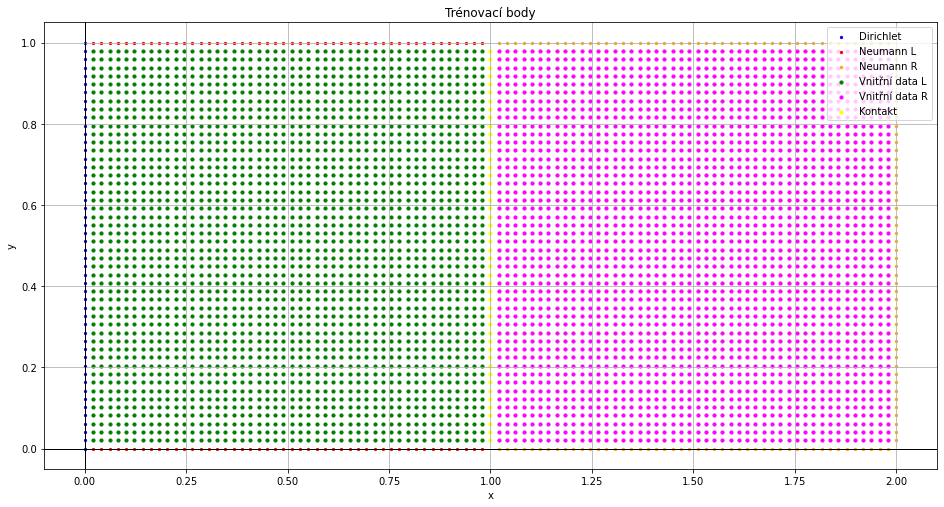

In [122]:
# Krok 2.1: Vygenerování trénovacích dat
(pts_interior_L, pts_interior_R, pts_neumann_L, pts_neumann_R, pts_dirichlet_L, pts_contact, grad_mat_x, grad_mat_y, normals_L_neumann, normals_L_contact, normals_R_neumann) = sample_points(50)

In [123]:
# Krok 2.2: Inicializace NN a nastavení optimalizátoru
NN1 = MyModel()
NN2 = MyModel()
optimizer = optim.Adam(list(NN1.parameters()) + list(NN2.parameters()), lr=0.001)

In [124]:
# Krok 3.1: Definice funkce pro výpočet ztrátové funkce na levé membráně
def compute_loss_L(laplace, du_neumann, du_contact, du_contact_R, u_contact, u_contact_R, pts_interior_L, normals_L_neumann, normals_L_contact):
    f = force_function(pts_interior_L[:,1:2], 1).detach() # Zatížení membrány
    pde_loss = torch.mean((-laplace - f)**2) # Ztráta PDR

    du_neumann_x = du_neumann[:, 0].reshape(-1, 1)  
    du_neumann_y = du_neumann[:, 1].reshape(-1, 1)  
    dudn_neumann = (du_neumann_x * normals_L_neumann[:, 0].reshape(-1, 1) + du_neumann_y * normals_L_neumann[:, 1].reshape(-1, 1))
    neumann_loss = torch.mean((dudn_neumann)**2) # Ztráta na Neumannově hranici


    du_contact_x = du_contact[:, 0].reshape(-1, 1)  
    du_contact_y = du_contact[:, 1].reshape(-1, 1)  
    dudn_contact = (du_contact_x * normals_L_contact[:, 0].reshape(-1, 1) + du_contact_y * normals_L_contact[:, 1].reshape(-1, 1))

    du_contact_x_R = du_contact_R[:, 0].reshape(-1, 1)  
    du_contact_y_R = du_contact_R[:, 1].reshape(-1, 1)  
    dudn_contact_R = (du_contact_x_R * -normals_L_contact[:, 0].reshape(-1, 1) + du_contact_y_R * -normals_L_contact[:, 1].reshape(-1, 1))

    contact_loss_1 = torch.mean(torch.relu(u_contact - u_contact_R)**2)  # u(x) >= g
    contact_loss_2 = torch.mean(torch.relu(-dudn_contact_R)**2)  # du/dn >= 0
    contact_loss_3 = torch.mean(((u_contact_R - u_contact) * dudn_contact_R)**2)  # (u-g)du/dn = 0
    contact_loss_4 = torch.mean((dudn_contact_R + dudn_contact)**2)
    contact_loss = contact_loss_1 + contact_loss_2 + contact_loss_3 + contact_loss_4 # Ztráta na kontaktní hranici
    
    return (pde_loss, neumann_loss, contact_loss)

In [125]:
# Krok 3.2: Definice funkce pro výpočet ztrátové funkce na parvé membráně
def compute_loss_R(laplace_R, du_neumann_R, du_contact, du_contact_R, u_contact, u_contact_R, pts_interior_R, normals_R_neumann, normals_L_contact):  
    f_R = force_function(pts_interior_R[:,1:2], 2).detach()
    pde_loss_R = torch.mean((-laplace_R - f_R)**2) # Ztráta PDR

    du_neumann_x_R = du_neumann_R[:, 0].reshape(-1, 1)  
    du_neumann_y_R = du_neumann_R[:, 1].reshape(-1, 1)  
    dudn_neumann_R = (du_neumann_x_R * normals_R_neumann[:, 0].reshape(-1, 1) + du_neumann_y_R * normals_R_neumann[:, 1].reshape(-1, 1))
    neumann_loss_R = torch.mean((dudn_neumann_R)**2) # Ztráta na Neumannově hranici

    du_contact_x = du_contact[:, 0].reshape(-1, 1)  
    du_contact_y = du_contact[:, 1].reshape(-1, 1)  
    dudn_contact = (du_contact_x * normals_L_contact[:, 0].reshape(-1, 1) + du_contact_y * normals_L_contact[:, 1].reshape(-1, 1))

    du_contact_x_R = du_contact_R[:, 0].reshape(-1, 1)  
    du_contact_y_R = du_contact_R[:, 1].reshape(-1, 1)  
    dudn_contact_R = (du_contact_x_R * -normals_L_contact[:, 0].reshape(-1, 1) + du_contact_y_R * -normals_L_contact[:, 1].reshape(-1, 1))

    contact_loss_1 = torch.mean(torch.relu(u_contact - u_contact_R)**2)  # u(x) >= g
    contact_loss_2 = torch.mean(torch.relu(-dudn_contact_R)**2)  # du/dn >= 0
    contact_loss_3 = torch.mean(((u_contact_R - u_contact) * dudn_contact_R)**2)  # (u-g)du/dn = 0
    contact_loss_4 = torch.mean((dudn_contact_R + dudn_contact)**2)
    contact_loss_R = contact_loss_1 + contact_loss_2 + contact_loss_3 + contact_loss_4 # Ztráta na kontaktní hranici

    return (pde_loss_R, neumann_loss_R, contact_loss_R)

In [126]:
# Krok 3.3: Definice funkce closure pro výpočet ztráty při použití optimalizátoru Adam
def compute_loss_for_Adam():
    # LEVÁ MEMBRÁNA
    u_interior_L = pts_interior_L[:, 0:1] * NN1(pts_interior_L)
    u_neumann_L = pts_neumann_L[:, 0:1] * NN1(pts_neumann_L)
    u_contact_L = pts_contact[:, 0:1] * NN1(pts_contact)
    u_contact_R = NN2(pts_contact)

    # PDR
    du_int = torch.autograd.grad(torch.sum(u_interior_L), pts_interior_L, create_graph=True)[0]
    du_int_xx = torch.autograd.grad(du_int, pts_interior_L, grad_outputs=grad_mat_x, retain_graph=True, create_graph=True)[0][:, 0].reshape(-1, 1)
    du_int_yy = torch.autograd.grad(du_int, pts_interior_L, grad_outputs=grad_mat_y, retain_graph=True, create_graph=True)[0][:, 1].reshape(-1, 1)
    laplace = du_int_xx + du_int_yy

    # Neumann
    du_neumann = torch.autograd.grad(torch.sum(u_neumann_L), pts_neumann_L, create_graph=True)[0]
    du_contact = torch.autograd.grad(torch.sum(u_contact_L), pts_contact, create_graph=True)[0]
    du_contact_R = torch.autograd.grad(torch.sum(u_contact_R), pts_contact, create_graph=True)[0]

    # Ztráty na levé membráně
    (pde_loss_L, neumann_loss_L, contact_loss_L) = compute_loss_L(laplace, du_neumann, du_contact, du_contact_R, u_contact_L, u_contact_R, pts_interior_L, normals_L_neumann, normals_L_contact)

    # PRAVÁ MEMBRÁNA
    u_interior_R = NN2(pts_interior_R)
    u_neumann_R = NN2(pts_neumann_R)
   
    # PDR
    du_int_R = torch.autograd.grad(torch.sum(u_interior_R), pts_interior_R, create_graph=True)[0]
    du_int_xx_R = torch.autograd.grad(du_int_R, pts_interior_R, grad_outputs=grad_mat_x, retain_graph=True, create_graph=True)[0][:, 0].reshape(-1, 1)
    du_int_yy_R = torch.autograd.grad(du_int_R, pts_interior_R, grad_outputs=grad_mat_y, retain_graph=True, create_graph=True)[0][:, 1].reshape(-1, 1)
    laplace_R = du_int_xx_R + du_int_yy_R

    # Neumann
    du_neumann_R = torch.autograd.grad(torch.sum(u_neumann_R), pts_neumann_R, create_graph=True)[0]
    du_contact = torch.autograd.grad(torch.sum(u_contact_L), pts_contact, create_graph=True)[0]
    du_contact_R = torch.autograd.grad(torch.sum(u_contact_R), pts_contact, create_graph=True)[0]

    # Ztráty na pravé membráně
    (pde_loss_R, neumann_loss_R, contact_loss_R) = compute_loss_R(laplace_R, du_neumann_R, du_contact, du_contact_R, u_contact_L, u_contact_R, pts_interior_R, normals_R_neumann, normals_L_contact)
    
    # Celková ztráta s použitím adaptivních vah
    loss_sum = pde_loss_L + neumann_loss_L + contact_loss_L + pde_loss_R + neumann_loss_R + contact_loss_R
    loss = pde_loss_L**2/loss_sum + neumann_loss_L**2/loss_sum + contact_loss_L**2/loss_sum + pde_loss_R**2/loss_sum + neumann_loss_R**2/loss_sum + contact_loss_R**2/loss_sum

    return loss

In [127]:
# Krok 3.4: Definice funkce closure pro výpočet ztráty při použití optimalizátoru LBFGS
def closure():
    optimizer.zero_grad()

    loss = compute_loss_for_Adam()

    loss.backward(retain_graph=True)
    return loss

In [128]:
# Krok 4.1: Trénovací smyčka
epochs = 800
loss_values = []
best_loss = float('inf')  # Initialize with a high value
best_state = None         # To store the best model state
for epoch in range(epochs):
    if epoch <= epochs/2: # Učení NN při optimalizátoru Adam
        optimizer.zero_grad()
        loss = compute_loss_for_Adam()
        loss.backward()
        optimizer.step()
    else: # Učení NN při optimalizátoru LBFGS
        loss = optimizer.step(closure)
    loss_values.append(loss.detach().numpy())
    if loss.detach().item() < best_loss:
        best_loss = loss.detach().item()
        best_state = {'NN1_state': NN1.state_dict(), 'NN2_state': NN2.state_dict()}
    if epoch == 600: # Změna optimalizátoru - využití parametrů NN z nejlepší epochy
        print(f"Změna optimalizátoru v epoše {epoch + 1}. Použití NN s nejlepší ztrátou {best_loss:.4f}")
        NN1.load_state_dict(best_state['NN1_state'])
        NN2.load_state_dict(best_state['NN2_state'])
        optimizer = torch.optim.LBFGS(list(NN1.parameters()) + list(NN2.parameters()), lr=0.1, max_iter=20, history_size=10)

    if (epoch + 1) % 20 == 0:
        print(f'Epocha {epoch+1}/{epochs}, Ztráta: {loss.item()}')

Epocha 20/400, Ztráta: 0.9008036851882935
Epocha 40/400, Ztráta: 0.45297589898109436
Epocha 60/400, Ztráta: 0.3109113276004791
Epocha 80/400, Ztráta: 0.21882037818431854
Epocha 100/400, Ztráta: 0.12680834531784058
Epocha 120/400, Ztráta: 0.09361739456653595
Epocha 140/400, Ztráta: 0.06685508787631989
Epocha 160/400, Ztráta: 0.052806392312049866
Epocha 180/400, Ztráta: 0.04264844208955765
Epocha 200/400, Ztráta: 0.03603050857782364
Změna optimalizátoru v epoše 201. Použití NN s nejlepší ztrátou 0.0358
Epocha 220/400, Ztráta: 0.006911276839673519
Epocha 240/400, Ztráta: 0.0027136649005115032
Epocha 260/400, Ztráta: 0.0011388269485905766
Epocha 280/400, Ztráta: 0.0005842749960720539
Epocha 300/400, Ztráta: 0.00036561701563186944
Epocha 320/400, Ztráta: 0.00030318298377096653
Epocha 340/400, Ztráta: 0.00025180724333040416
Epocha 360/400, Ztráta: 0.00024005468003451824
Epocha 380/400, Ztráta: 0.00021631989511661232
Epocha 400/400, Ztráta: 0.00020746779046021402


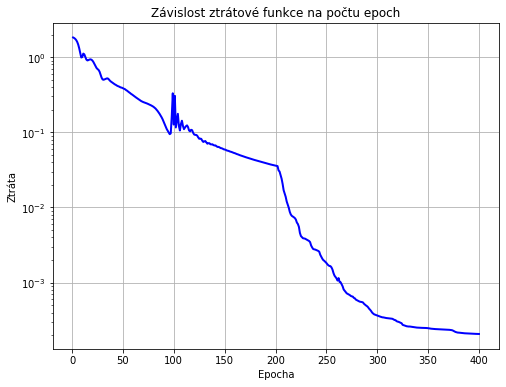

In [129]:
# Krok 4.2: Graf znázorňující závislost ztráty na počtu epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values, color='blue', linewidth=2)
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch')
plt.xlabel('Epocha')
plt.ylabel('Ztráta')
plt.grid(True)
plt.show()

In [130]:
# Krok 5.1: Definice funkce pro vykreslení predikce řešení NN při náhodných testovacích datech
def plot_predictions_random(points_combined_np, u_pred_combined_np):
    # 2D graf
    plt.figure(figsize=(8, 6))
    plt.scatter(points_combined_np[:,0:1], points_combined_np[:,1:2], c =u_pred_combined_np, cmap='jet', s=30)
    plt.colorbar(label='u(x,y)')
    plt.title('Aproximace řešení NN')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

    x_combined = points_combined_np[:, 0]
    y_combined = points_combined_np[:, 1]
    z_combined = u_pred_combined_np.flatten()  # Zaručení 1D tvaru tenzoru

    # 3D graf
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(x_combined, y_combined, z_combined, c=z_combined, cmap='jet', s=10)

    cbar = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
    cbar.set_label('u(x,y)')
    ax.set_title('Aproximace řešení NN')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("u(x,y)")

    plt.show()

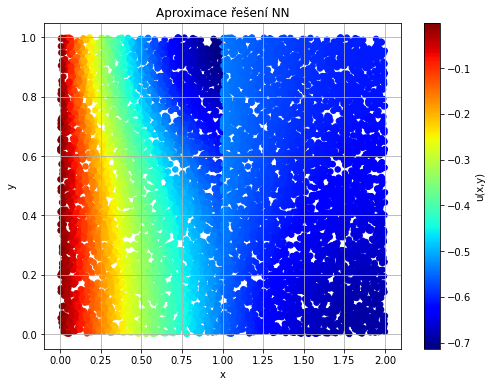

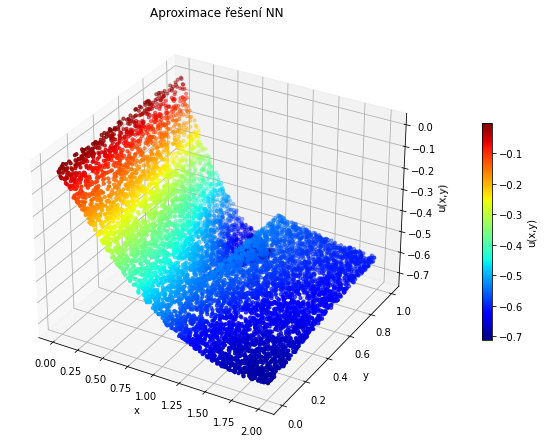

In [131]:
# Krok 5.2: Testování NN pro náhodně rozložená data
x_test = torch.rand(4000, 1)
y_test = torch.rand(4000, 1)

with torch.no_grad():
    # Levá membrána
    inputs = torch.cat([x_test, y_test], dim=1)
    u_pred = NN1(inputs)

    # Pravá membrána
    inputs_R = torch.cat([x_test + 1, y_test], dim=1)
    u_pred_R = NN2(inputs_R)

    u_pred = x_test * u_pred


# Spojení bodů a predikcí
points_combined = torch.cat([inputs, inputs_R], dim=0) 
u_pred_combined = torch.cat([u_pred, u_pred_R], dim=0) 

points_combined_np = points_combined.numpy()
u_pred_combined_np = u_pred_combined.numpy()

plot_predictions_random(points_combined_np, u_pred_combined_np)

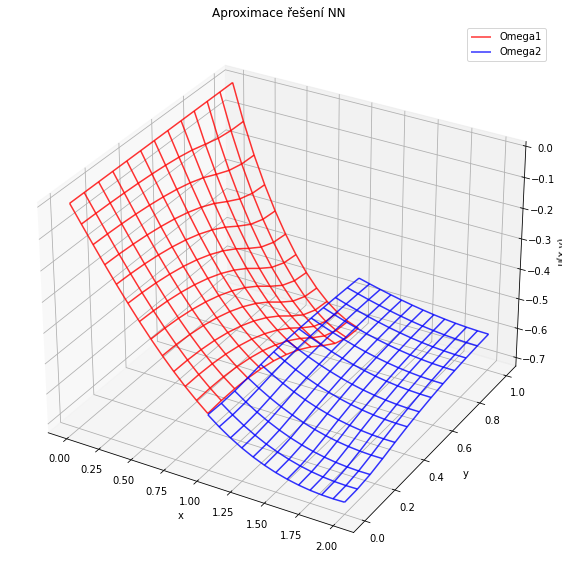

In [132]:
# Krok 5.3: Testování NN a vykreslení predikcí na rovnoměrně rozložených datech
num_points = 25
# Levá membrána
x1_lin = torch.linspace(0, 1, num_points)
y1_lin = torch.linspace(0, 1, num_points)
x1_grid, y1_grid = torch.meshgrid(x1_lin, y1_lin)
Omega1 = torch.stack((x1_grid.flatten(), y1_grid.flatten()), dim=1)
# Pravá membrána
x2_lin = torch.linspace(1, 2, num_points)
y2_lin = torch.linspace(0, 1, num_points)
x2_grid, y2_grid = torch.meshgrid(x2_lin, y2_lin)
Omega2 = torch.stack((x2_grid.flatten(), y2_grid.flatten()), dim=1)

Omega1_test = Omega1.reshape(-1, 2)
Omega2_test = Omega2.reshape(-1, 2)

# Testování NN
with torch.no_grad():
    pred_Omega1 = NN1(Omega1_test).squeeze().numpy()
    pred_Omega2 = NN2(Omega2_test).squeeze().numpy()
    pred_Omega1 = Omega1_test[:, 0].numpy() * pred_Omega1

Omega1_x, Omega1_y = Omega1_test[:, 0].numpy(), Omega1_test[:, 1].numpy()
Omega2_x, Omega2_y = Omega2_test[:, 0].numpy(), Omega2_test[:, 1].numpy()

# Mřížky pro intorpolaci predikcí
grid_size = 13
x1_grid, y1_grid = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
x2_grid, y2_grid = np.meshgrid(np.linspace(1, 2, grid_size), np.linspace(0, 1, grid_size))

# Interpolace predikcí
z1_grid = griddata((Omega1_x, Omega1_y), pred_Omega1, (x1_grid, y1_grid), method='cubic')
z2_grid = griddata((Omega2_x, Omega2_y), pred_Omega2, (x2_grid, y2_grid), method='cubic')

# 3D graf
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(x1_grid, y1_grid, z1_grid, color='red', label='Omega1', alpha=0.8, linewidth=1.5)
ax.plot_wireframe(x2_grid, y2_grid, z2_grid, color='blue', label='Omega2', alpha=0.8, linewidth=1.5)
ax.set_title("Aproximace řešení NN")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")

# Add a legend
ax.legend()

# Show the plot
plt.show()